In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from Bayesian_SIR import Bayesian_SIR
import pandas as pd
from pysmooth import smooth
import csv
plt.rcParams['font.size'] = 14

### Parameter initialization

In [2]:
N = 1_000_000
T = 101
I0 = 50

betas = 25*[0.3]+25*[.4]+25*[.25]+26*[.2]
gammas = 25*[0.05]+25*[.15]+25*[.2]+26*[.25]

SIR_model = Bayesian_SIR([N, T, I0], betas, gammas)

### Simulation

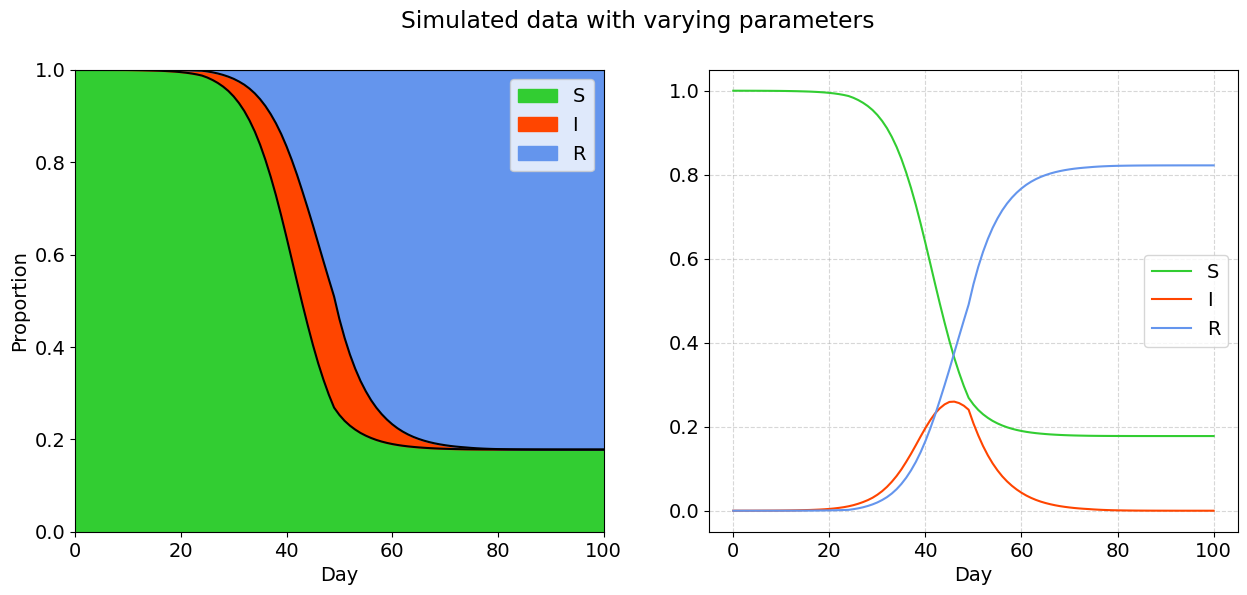

In [3]:
SIR_model.simulation(save='img')

## Full run on simulated data

In [4]:
n_steps = 25_000
p = 0.01
T = T - 1
burnin = 5_000
thin = 10

SIR_model.run(p, n_steps, burnin, thin)

Updating beta, gamma and delta parameters...


Buffering...:   0%|          | 0/25000 [00:00<?, ?it/s]

## Bayesian estimators

In [5]:
deltas_samples = SIR_model.deltas_samples
bs_samples = SIR_model.bs_samples
rs_samples = SIR_model.rs_samples
betas_samples = SIR_model.betas_samples
gammas_samples = SIR_model.gammas_samples

In [6]:
betas_mean = np.mean(betas_samples, axis=1)
betas_mean.reshape(4, 25).mean(axis=1)

array([0.30948284, 0.39401079, 0.2494215 , 0.25654262])

In [7]:
gammas_mean = np.mean(gammas_samples, axis=1)
gammas_mean.reshape(4, 25).mean(axis=1)

array([0.05889887, 0.15202553, 0.20191735, 0.27237411])

In [8]:
colors = ["royalblue", "limegreen"]

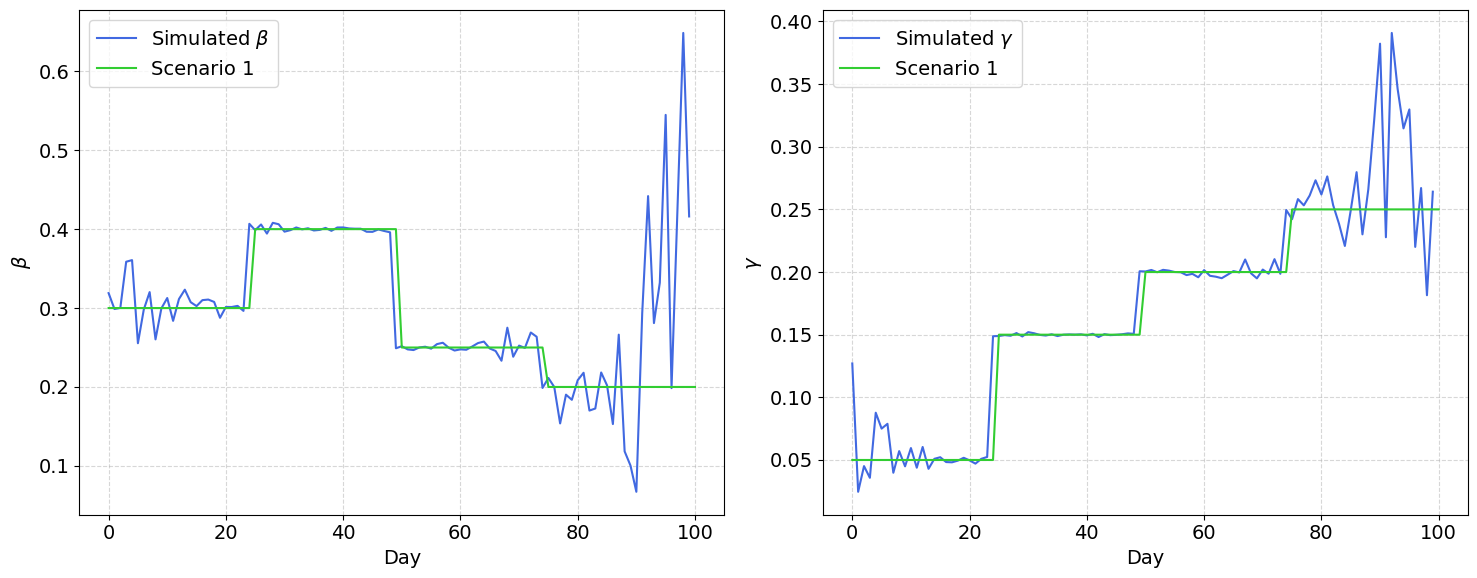

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(betas_mean, color=colors[0], label='Simulated '+r'$\beta$')
ax[0].plot(betas, color=colors[1], label=f'Scenario 1')
ax[0].legend()
ax[0].set_xlabel('Day')
ax[0].set_ylabel(r'$\beta$')
ax[0].grid(ls='--', alpha=0.5)

ax[1].plot(gammas_mean, color=colors[0], label='Simulated '+r'$\gamma$')
ax[1].plot(gammas, color=colors[1], label=f'Scenario 1')
ax[1].legend()
ax[1].set_xlabel('Day')
ax[1].set_ylabel(r'$\gamma$')
ax[1].grid(ls='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f'img/comparison_simulation.png', dpi=500)
plt.show()

## Find Bayes estimator $\hat{\delta}$

In [10]:
SIR_model.find_Bayes_delta()
delta_final = SIR_model.delta_final

Finding best delta minimizing the loss...


Loading...:   0%|          | 0/100 [00:00<?, ?it/s]

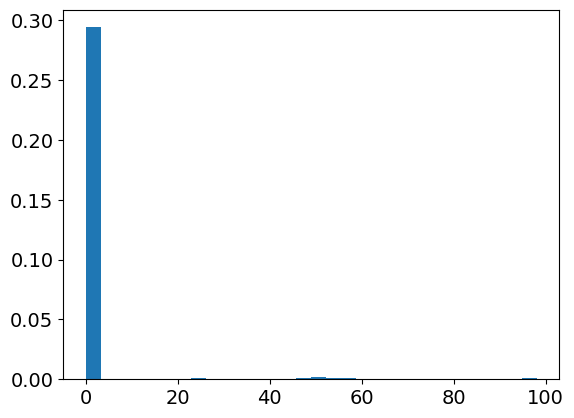

In [11]:
where = np.where(deltas_samples == 1)[0]
plt.hist(where, bins = 30, density=True);

In [12]:
sum(np.sum(deltas_samples, axis=0) > 2)

2

In [13]:
delta_final

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
np.where(delta_final == 1)[0]

array([0], dtype=int64)

In [15]:
SIR_model.ARI(delta_final, np.array(([1]+[0]*24)*4))

-1.9051427102567757e-15

In [16]:
SIR_model.MI(delta_final, np.array(([1]+[0]*24)*4))

0.0

In [17]:
SIR_model_real = Bayesian_SIR([None]*3, [], [])
data = pd.read_csv('Singapore_new.csv')

# Smooth variables:
data["New_Recovered"] = smooth(x=data["New_Recovered"], kind="3RS3R", twiceit=False, endrule="Tukey")
data["New_Infectious"] = smooth(x=data["New_Infectious"], kind="3RS3R", twiceit=False, endrule="Tukey")

data.to_csv('Singapore_new_smoothed.csv')

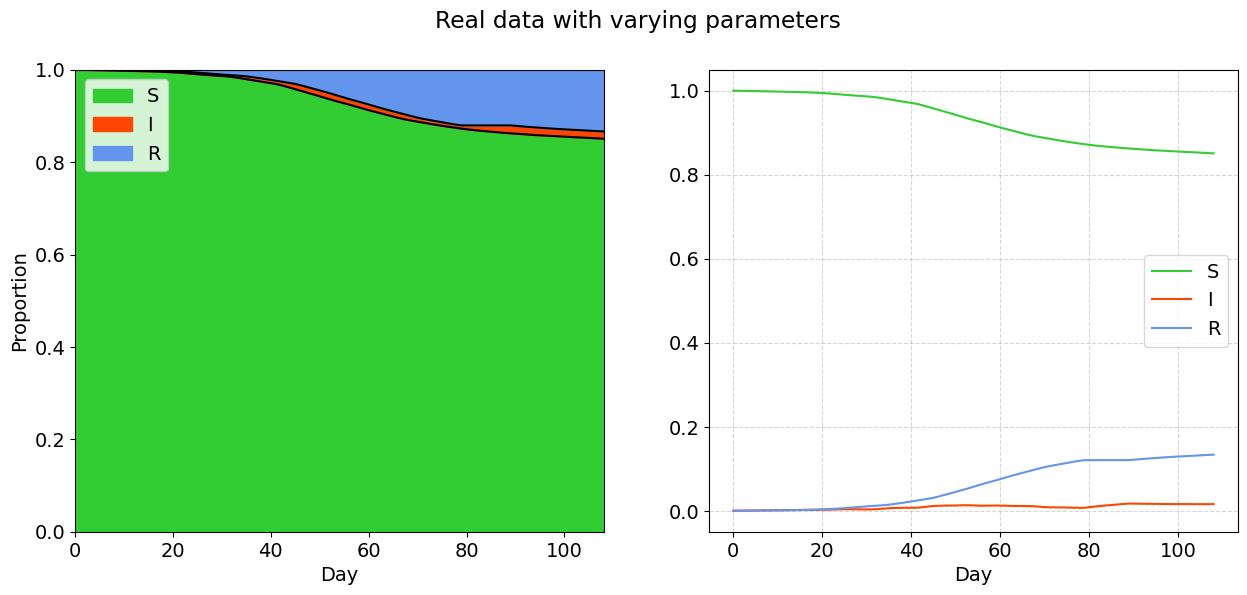

Updating beta, gamma and delta parameters...


Buffering...:   0%|          | 0/25000 [00:00<?, ?it/s]

In [18]:
n_steps = 25_000
p = 0.01
burnin = 5_000
thin = 10

SIR_model_real.run(p, n_steps, burnin, thin, 
                   data_file='Singapore_new_smoothed.csv', save='img')

In [19]:
deltas_samples_real = SIR_model_real.deltas_samples
bs_samples_real = SIR_model_real.bs_samples
rs_samples_real = SIR_model_real.rs_samples
betas_samples_real = SIR_model_real.betas_samples
gammas_samples_real = SIR_model_real.gammas_samples

## Comparison between fitted $\beta$ and $\gamma$ with respect to those shown in the paper

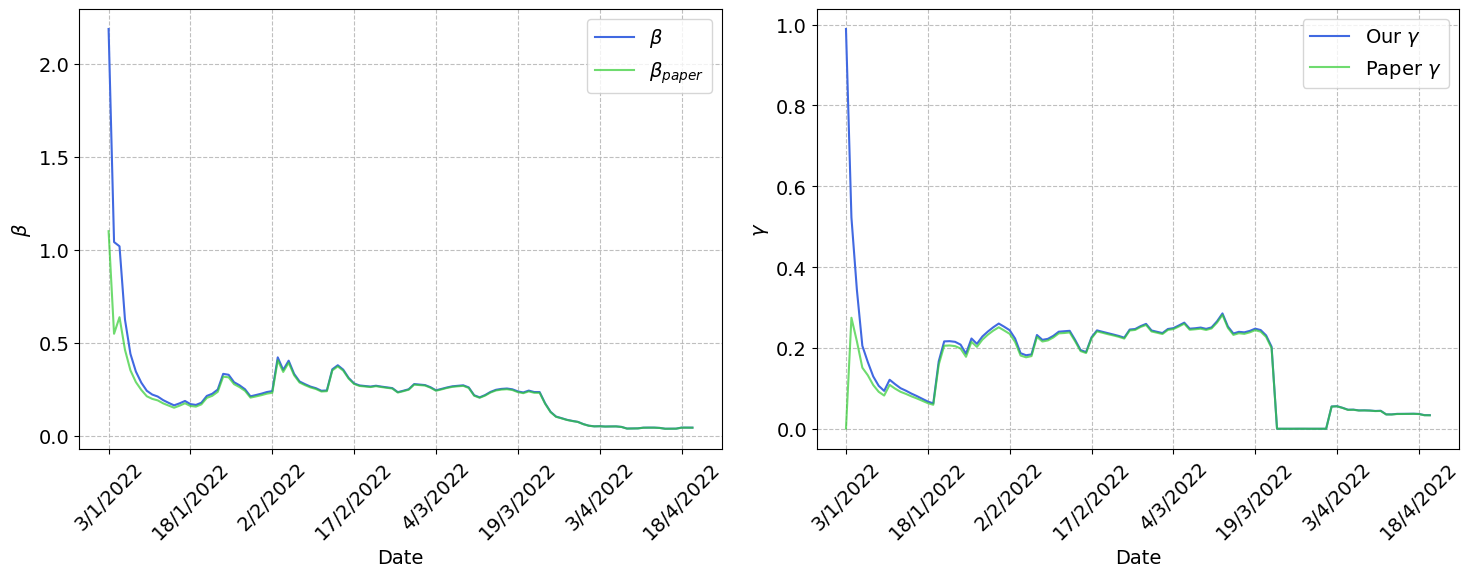

In [20]:
betas_samples_real_mean = np.mean(betas_samples_real, axis=1)
with open('Beta_all.csv', 'r') as f:
    reader = csv.reader(f)
    their_beta = list(reader)
their_beta = np.array(their_beta[1:], dtype=np.double).mean(axis=0)
gammas_samples_real_mean = np.mean(gammas_samples_real, axis=1)
with open('Gamma_all.csv', 'r') as f:
    reader = csv.reader(f)
    their_gamma = list(reader)
their_gamma = np.array(their_gamma[1:], dtype=np.double).mean(axis=0)


fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(betas_samples_real_mean, label=r'$\beta$', color=colors[0])
ax[0].plot(their_beta, label=r'$\beta_{paper}$', color=colors[1], alpha=0.7)
ax[0].set_xlabel('Date')
ax[0].set_xticks(range(0, 109, 15), np.array(data.Date[::15]), rotation=45)
ax[0].set_ylabel(r'$\beta$')
ax[0].grid(ls='--', alpha=0.8)
ax[0].legend()

ax[1].plot(gammas_samples_real_mean, label=r'Our $\gamma$', color=colors[0])
ax[1].plot(their_gamma, label=r'Paper $\gamma$', color=colors[1], alpha=0.7)
ax[1].set_xlabel('Date')
ax[1].set_xticks(range(0, 109, 15), np.array(data.Date[::15]), rotation=45)
ax[1].set_ylabel(r'$\gamma$')
ax[1].grid(ls='--', alpha=0.8)
ax[1].legend()

plt.tight_layout()
plt.savefig(f'img/beta_gamma_real_df.png', dpi=500)
plt.show()

## Comparison between fitted $\delta$ and those provided:

In [21]:
where = np.where(deltas_samples_real[1:] == 1)[0]
with open('Delta_all.csv', 'r') as f:
    reader = csv.reader(f)
    their_delta = list(reader)
their_delta = np.array(their_delta[1:], dtype=int).T
where_their = np.where(their_delta[1:] == 1)[0]

SIR_model_real.find_Bayes_delta()
delta_final_real = SIR_model_real.delta_final
delta_final_real

Finding best delta minimizing the loss...


Loading...:   0%|          | 0/100 [00:00<?, ?it/s]

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

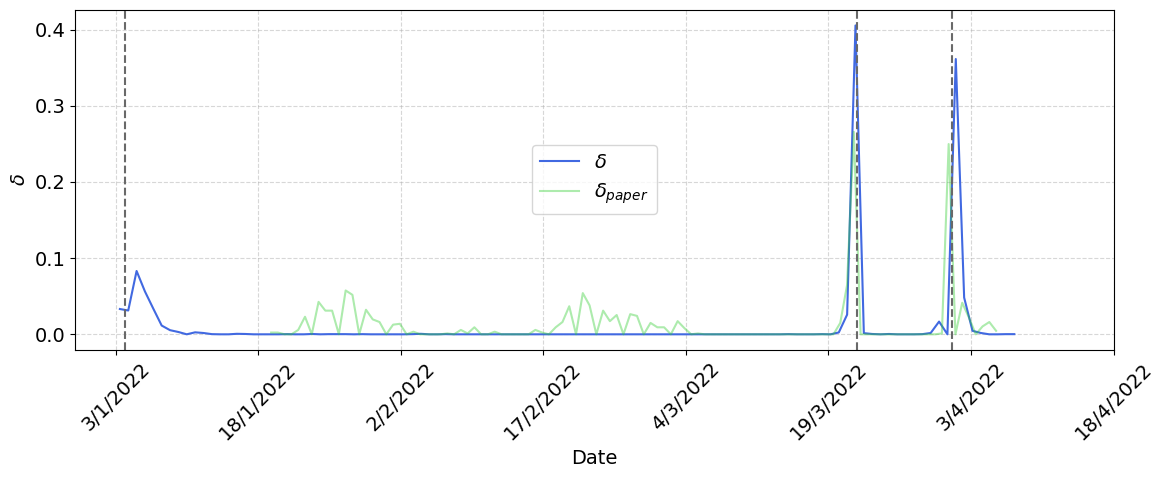

In [22]:
n_wh, wh_bins = np.histogram(where[1:], bins=108, density=True)
n_their, wh_bins_their = np.histogram(where_their, bins=108, density=True)
plt.figure(figsize=(12, 5))
plt.plot((wh_bins[1:]+wh_bins[:-1])/2, n_wh, label=r'$\delta$', color=colors[0])
plt.plot((wh_bins_their[1:]+wh_bins_their[:-1])/2, n_their,
            label=r'$\delta_{paper}$', color=colors[1], alpha=0.4)
lims = plt.ylim()
for en, d in enumerate(delta_final_real[1:]):
    if d == 1:
        plt.vlines(en, *lims, color='dimgray', ls='--')
plt.ylim(lims)
plt.xlabel('Date')
plt.xticks(range(0, 108, 15), np.array(data.Date[::15]), rotation=45)
plt.ylabel(r'$\delta$')
plt.grid(ls='--', alpha=0.5)
plt.legend(loc='center')
plt.tight_layout()
plt.savefig(f'img/delta_Singapore.png', dpi=500)
plt.show()

## Transmission & Removal rates

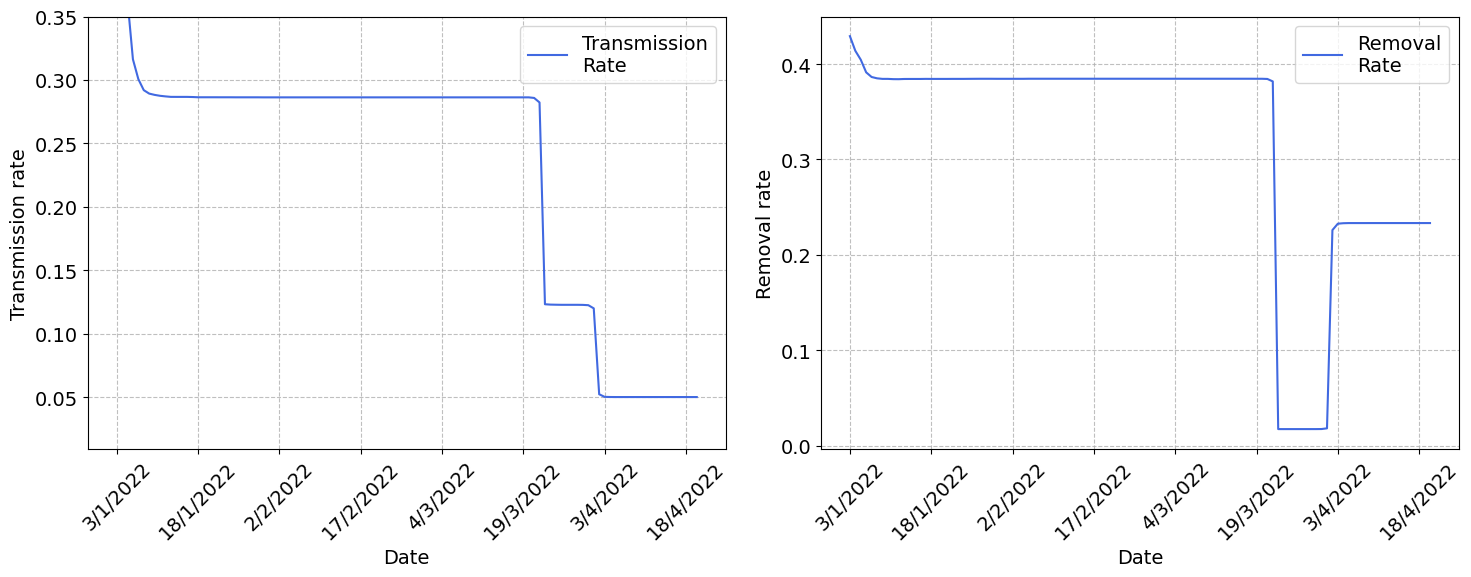

In [30]:
bs_median = np.median(1/bs_samples_real, axis = 1)
rs_median = np.median(rs_samples_real/(1+rs_samples_real), axis = 1)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(bs_median, color=colors[0], label='Transmission\nRate')
ax[0].set_xlabel('Date')
ax[0].set_xticks(range(0, 109, 15), np.array(data.Date[::15]), rotation=45)
ax[0].set_ylabel(f'Transmission rate')
lims = ax[0].get_ylim()
ax[0].set_ylim(lims[0], 0.35)
ax[0].grid(ls='--', alpha=0.8)
ax[0].legend()

ax[1].plot(rs_median, color=colors[0], label='Removal\nRate')
ax[1].set_xlabel('Date')
ax[1].set_xticks(range(0, 109, 15), np.array(data.Date[::15]), rotation=45)
ax[1].set_ylabel(f'Removal rate')
ax[1].grid(ls='--', alpha=0.8)
ax[1].legend()

plt.tight_layout()
plt.savefig(f'img/Transmission_Removal_Rates.png', dpi=500)
plt.show()

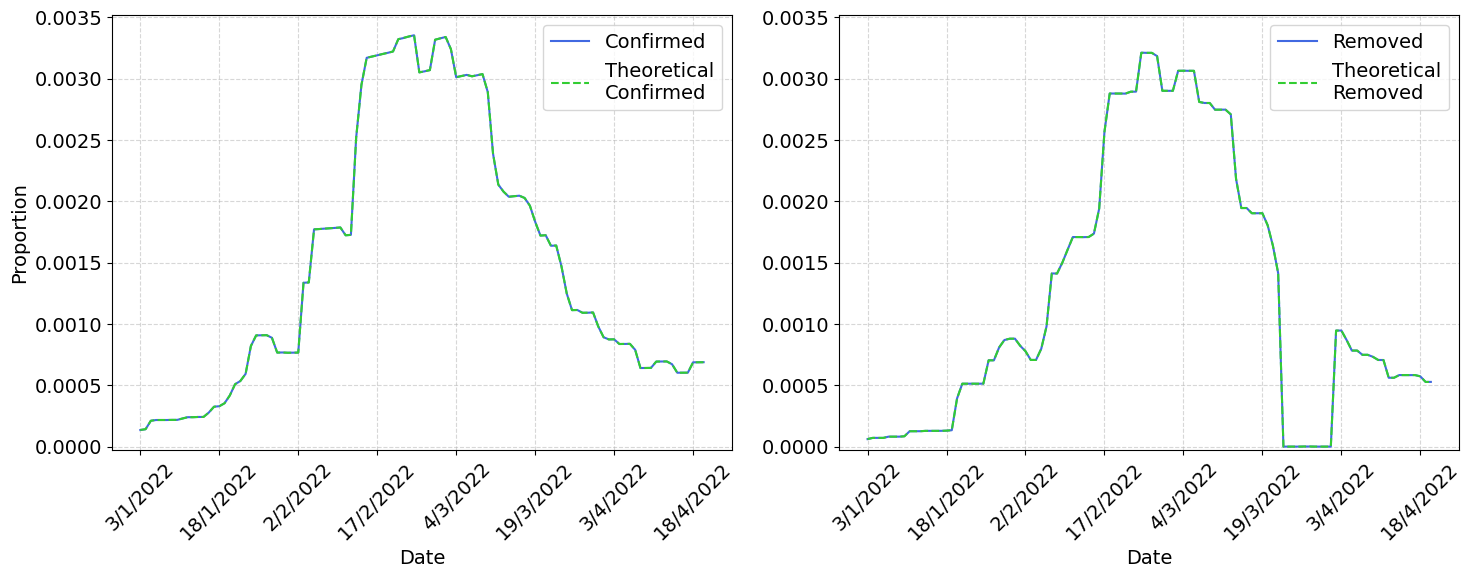

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(betas_samples_real_mean*SIR_model_real.configurations[:-1, 1]/SIR_model_real.N, color=colors[0], label='Confirmed')
betas_tilde = -np.log(1+np.diff(SIR_model_real.configurations[:, 0])/SIR_model_real.configurations[:-1, 0])/(SIR_model_real.configurations[:-1, 1]/SIR_model_real.N)
ax[0].plot(betas_tilde*SIR_model_real.configurations[:-1, 1]/SIR_model_real.N, ls='--', color=colors[1], label='Theoretical\nConfirmed')
ax[0].legend()
lims = ax[0].get_ylim()
ax[0].grid(ls='--', alpha=0.5)
ax[0].set_xlabel('Date')
ax[0].set_xticks(range(0, 109, 15), np.array(data.Date[::15]), rotation=45)
ax[0].set_ylabel(f'Proportion')

ax[1].plot(gammas_samples_real_mean*SIR_model_real.configurations[:-1, 1]/SIR_model_real.N, color=colors[0], label='Removed')
gammas_tilde = np.diff(SIR_model_real.configurations[:, 2])/SIR_model_real.configurations[:-1, 1]
ax[1].plot(gammas_tilde*SIR_model_real.configurations[:-1, 1]/SIR_model_real.N, color=colors[1], ls='--', label='Theoretical\nRemoved')
ax[1].legend()
ax[1].grid(ls='--', alpha=0.5)
ax[1].set_ylim(*lims)
ax[1].set_xlabel('Date')
ax[1].set_xticks(range(0, 109, 15), np.array(data.Date[::15]), rotation=45)

plt.tight_layout()
plt.savefig(f'img/Confirmed_Removed.png', dpi=500)
plt.show()

In [23]:
with open('Delta_all.csv', 'r') as f:
    reader = csv.reader(f)
    loro = list(reader)
loro = np.array(loro[1:], dtype=np.double)

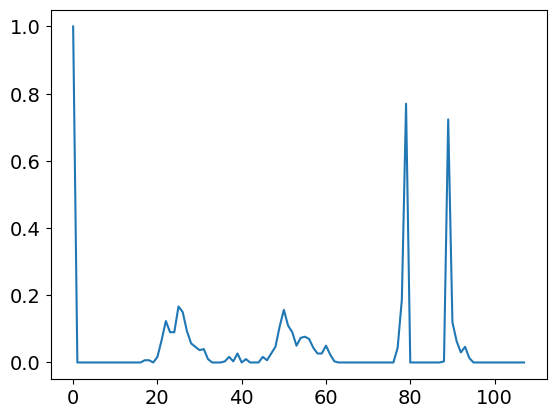

In [24]:
loro_mean = np.mean(loro, axis=0)
plt.plot(loro_mean);

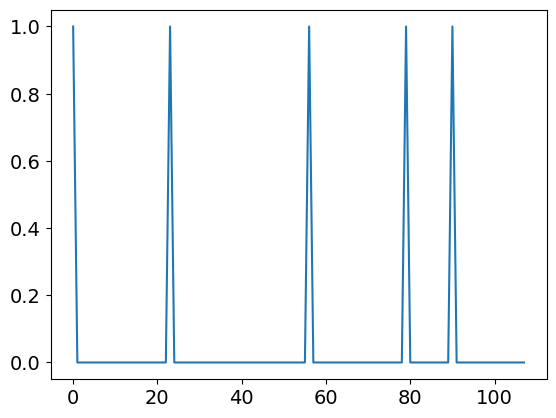

In [25]:
plt.plot(loro[-1, :]);